In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch

# Yeni klasör yolu
data_dir = "C:/Users/alper/bitirme/BrainTumor"

# Görüntü dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Veriyi yükle
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Sınıf indeksleri (0: no_tumor, 1: tumor) olduğunu doğrula
print("Sınıflar:", dataset.classes)
print("Sınıf indexleri:", dataset.class_to_idx)

# Görselleri ve etiketleri tensöre çevir
all_images = [img for img, _ in dataset]
all_labels = [label for _, label in dataset]

all_images = torch.stack(all_images)
all_labels = torch.tensor(all_labels)

# Eğitim/test bölmesi
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# TensorDataset ve DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train ve test DataLoader'ları hazır.")


Sınıflar: ['no_tumor', 'tumor']
Sınıf indexleri: {'no_tumor': 0, 'tumor': 1}
Train ve test DataLoader'ları hazır.


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BrainCNN(nn.Module):
    def __init__(self):
        super(BrainCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 224 → 112 → 56 → 28 → 14
        self.fc2 = nn.Linear(512, 2)  # 2 sınıf (no_tumor, tumor)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224x224 → 112x112
        x = self.pool(F.relu(self.conv2(x)))  # 112x112 → 56x56
        x = self.pool(F.relu(self.conv3(x)))  # 56x56 → 28x28
        x = self.pool(F.relu(self.conv4(x)))  # 28x28 → 14x14
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Model oluştur ve cihaza taşı
cnn_brain = BrainCNN().to(device)

# Loss ve optimizer
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_brain.parameters(), lr=0.001)

print("CNN modeli tanımlandı ve hazır.")

CNN modeli tanımlandı ve hazır.


In [5]:
epochs = 10  # isteğe bağlı artırılabilir

for epoch in range(epochs):
    cnn_brain.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_cnn.zero_grad()
        outputs = cnn_brain(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Test doğruluğu
    cnn_brain.eval()
    test_correct = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_outputs = cnn_brain(test_images)
            _, test_predicted = torch.max(test_outputs, 1)
            test_correct += (test_predicted == test_labels).sum().item()

    test_accuracy = 100 * test_correct / len(test_dataset)

    print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy after epoch {epoch+1}: {test_accuracy:.2f}%\n")

# Modeli kaydet
torch.save(cnn_brain.state_dict(), "cnn_brain_model.pth")
print("CNN modeli 'cnn_brain_model.pth' olarak kaydedildi.")


[Epoch 1/10] Loss: 0.3218, Train Accuracy: 87.72%
Test Accuracy after epoch 1: 89.55%

[Epoch 2/10] Loss: 0.2162, Train Accuracy: 91.42%
Test Accuracy after epoch 2: 92.51%

[Epoch 3/10] Loss: 0.1725, Train Accuracy: 92.90%
Test Accuracy after epoch 3: 93.21%

[Epoch 4/10] Loss: 0.1448, Train Accuracy: 94.47%
Test Accuracy after epoch 4: 93.21%

[Epoch 5/10] Loss: 0.0917, Train Accuracy: 96.47%
Test Accuracy after epoch 5: 95.12%

[Epoch 6/10] Loss: 0.0657, Train Accuracy: 97.39%
Test Accuracy after epoch 6: 95.82%

[Epoch 7/10] Loss: 0.0348, Train Accuracy: 98.74%
Test Accuracy after epoch 7: 96.17%

[Epoch 8/10] Loss: 0.0207, Train Accuracy: 99.17%
Test Accuracy after epoch 8: 97.21%

[Epoch 9/10] Loss: 0.0159, Train Accuracy: 99.39%
Test Accuracy after epoch 9: 96.86%

[Epoch 10/10] Loss: 0.0133, Train Accuracy: 99.48%
Test Accuracy after epoch 10: 96.34%

CNN modeli 'cnn_brain_model.pth' olarak kaydedildi.


In [6]:
from torchvision.models import vgg19, VGG19_Weights
import torch.nn as nn

# VGG19 modelini önceden eğitilmiş olarak yükle
weights = VGG19_Weights.DEFAULT
vgg19 = vgg19(weights=weights)

# Son katmanı (classifier) 2 sınıfa göre değiştir ('no tumor' - 'tumor')
vgg19.classifier[6] = nn.Linear(4096, 2)

print("VGG19 modeli yüklendi ve son katman 2 sınıfa göre güncellendi.")


VGG19 modeli yüklendi ve son katman 2 sınıfa göre güncellendi.


In [7]:
# Cihazı tanımla (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli cihaza taşı
vgg19 = vgg19.to(device)

# Optimizasyon ve loss fonksiyonu
optimizer_vgg = optim.Adam(vgg19.parameters(), lr=0.0001)
criterion_vgg = nn.CrossEntropyLoss()

print("Model cihaza taşındı, optimizer ve loss fonksiyonu ayarlandı.")


Model cihaza taşındı, optimizer ve loss fonksiyonu ayarlandı.


In [8]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# Eğitim ayarları
epochs = 10
vgg19.to(device)
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg19.parameters(), lr=0.0001)

for epoch in range(epochs):
    # Eğitim
    vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_vgg.zero_grad()
        outputs = vgg19(images)
        loss = criterion_vgg(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Değerlendirme 
    vgg19.eval()
    test_correct = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_outputs = vgg19(test_images)

            probs = F.softmax(test_outputs, dim=1)[:, 1]  # pozitif sınıfın olasılığı
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

            _, test_predicted = torch.max(test_outputs, 1)
            test_correct += (test_predicted == test_labels).sum().item()

    test_accuracy = 100 * test_correct / len(test_dataset)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%, ROC-AUC: {roc_auc:.4f}\n")

# Modeli kaydet
torch.save(vgg19.state_dict(), "vgg19_brain_model.pth")
print("VGG19 modeli 'vgg19_brain_model.pth' olarak kaydedildi.")


[Epoch 1/10] Loss: 0.2013, Train Accuracy: 91.86%
Test Accuracy: 97.56%, ROC-AUC: 0.9949

[Epoch 2/10] Loss: 0.0792, Train Accuracy: 97.08%
Test Accuracy: 98.26%, ROC-AUC: 0.9974

[Epoch 3/10] Loss: 0.0857, Train Accuracy: 97.47%
Test Accuracy: 98.08%, ROC-AUC: 0.9923

[Epoch 4/10] Loss: 0.0680, Train Accuracy: 97.65%
Test Accuracy: 97.39%, ROC-AUC: 0.9941

[Epoch 5/10] Loss: 0.0533, Train Accuracy: 98.61%
Test Accuracy: 98.61%, ROC-AUC: 0.9965

[Epoch 6/10] Loss: 0.0283, Train Accuracy: 99.04%
Test Accuracy: 98.26%, ROC-AUC: 0.9957

[Epoch 7/10] Loss: 0.0860, Train Accuracy: 98.04%
Test Accuracy: 97.04%, ROC-AUC: 0.9961

[Epoch 8/10] Loss: 0.0312, Train Accuracy: 99.13%
Test Accuracy: 97.91%, ROC-AUC: 0.9972

[Epoch 9/10] Loss: 0.0334, Train Accuracy: 98.95%
Test Accuracy: 98.43%, ROC-AUC: 0.9988

[Epoch 10/10] Loss: 0.0148, Train Accuracy: 99.56%
Test Accuracy: 99.13%, ROC-AUC: 0.9909

VGG19 modeli 'vgg19_brain_model.pth' olarak kaydedildi.


In [9]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Önceden eğitilmiş ResNet18 modelini yükle
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Son katmanı değiştir (2 sınıflı problem için)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

print("ResNet18 modeli yüklendi ve son katman güncellendi.")

ResNet18 modeli yüklendi ve son katman güncellendi.


In [10]:
# Cihaz ayarı
resnet18 = resnet18.to(device)

criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.0001)

print("Model cihaza taşındı, optimizer ve loss fonksiyonu ayarlandı.")

Model cihaza taşındı, optimizer ve loss fonksiyonu ayarlandı.


In [11]:
# Eğitim fonksiyonu
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / len(dataloader.dataset)
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

# Test/Değerlendirme fonksiyonu
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = F.softmax(outputs, dim=1)[:, 1]  # Pozitif sınıfın olasılığı
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / len(dataloader.dataset)
    roc_auc = roc_auc_score(all_labels, all_probs)
    return accuracy, roc_auc

# Eğitim döngüsü
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet18, train_loader, criterion_resnet, optimizer_resnet, device)
    test_acc, roc_auc = evaluate_model(resnet18, test_loader, device)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%, ROC-AUC: {roc_auc:.4f}\n")

# Modeli Kaydet
torch.save(resnet18.state_dict(), 'resnet18_brain_model.pth')
print("ResNet18 modeli 'resnet18_brain_model.pth' olarak kaydedildi.")

[Epoch 1/10] Train Loss: 0.1812, Train Accuracy: 93.25%
Test Accuracy: 98.61%, ROC-AUC: 0.9994

[Epoch 2/10] Train Loss: 0.0271, Train Accuracy: 99.26%
Test Accuracy: 98.61%, ROC-AUC: 0.9987

[Epoch 3/10] Train Loss: 0.0128, Train Accuracy: 99.74%
Test Accuracy: 99.13%, ROC-AUC: 0.9999

[Epoch 4/10] Train Loss: 0.0074, Train Accuracy: 99.87%
Test Accuracy: 99.13%, ROC-AUC: 0.9997

[Epoch 5/10] Train Loss: 0.0027, Train Accuracy: 100.00%
Test Accuracy: 99.13%, ROC-AUC: 0.9998

[Epoch 6/10] Train Loss: 0.0012, Train Accuracy: 100.00%
Test Accuracy: 98.95%, ROC-AUC: 0.9998

[Epoch 7/10] Train Loss: 0.0019, Train Accuracy: 99.96%
Test Accuracy: 99.13%, ROC-AUC: 0.9934

[Epoch 8/10] Train Loss: 0.0015, Train Accuracy: 100.00%
Test Accuracy: 99.30%, ROC-AUC: 0.9996

[Epoch 9/10] Train Loss: 0.0077, Train Accuracy: 99.87%
Test Accuracy: 94.77%, ROC-AUC: 0.9821

[Epoch 10/10] Train Loss: 0.0216, Train Accuracy: 99.30%
Test Accuracy: 99.13%, ROC-AUC: 0.9980

ResNet18 modeli 'resnet18_brain_mode

CNN Model - Confusion Matrix:
[[ 67  12]
 [  9 486]]

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.88      0.85      0.86        79
       Tumor       0.98      0.98      0.98       495

    accuracy                           0.96       574
   macro avg       0.93      0.91      0.92       574
weighted avg       0.96      0.96      0.96       574



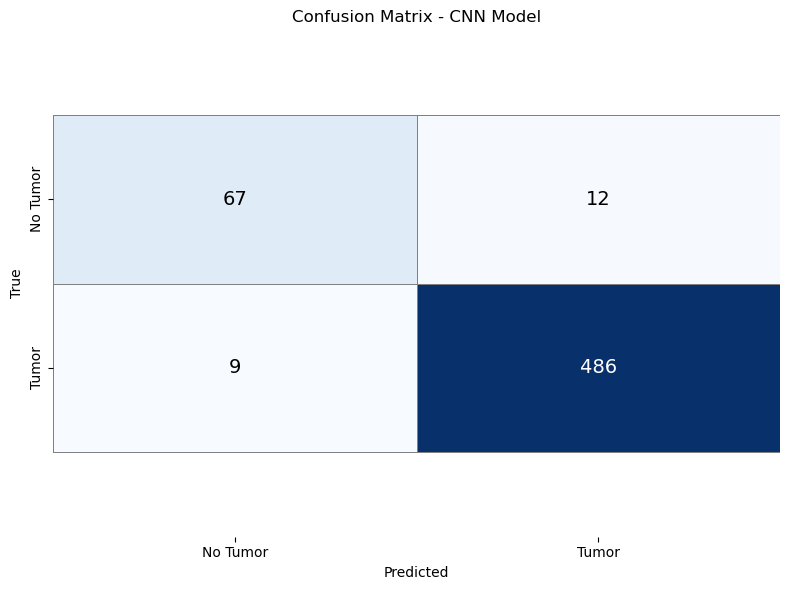

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin test verileri üzerinde tahmin yapması
cnn_brain.eval()  # veya kullandığın modelin ismi
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_brain(inputs)  # kullandığın modele göre değiştir
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Etiketler ve sınıf isimleri
labels = [0, 1]
class_names = ['No Tumor', 'Tumor']  # Brain tümör sınıflandırmasına göre isimlendirme

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=labels)
print("CNN Model - Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, labels=labels, target_names=class_names))

# Görselleştirme
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=False, linewidths=0.5, linecolor='gray')

# Sayıları manuel yaz (hem üst hem alt düzgün görünür)
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > threshold else "black"
        ax.text(j + 0.5, i + 0.5, str(value),
                ha='center', va='center', color=color, fontsize=14)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Model')

# Kaymayı engelle (özellikle alt satır için)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.show()


VGG19 - Confusion Matrix:
[[ 75   4]
 [  1 494]]

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.99      0.95      0.97        79
       Tumor       0.99      1.00      0.99       495

    accuracy                           0.99       574
   macro avg       0.99      0.97      0.98       574
weighted avg       0.99      0.99      0.99       574



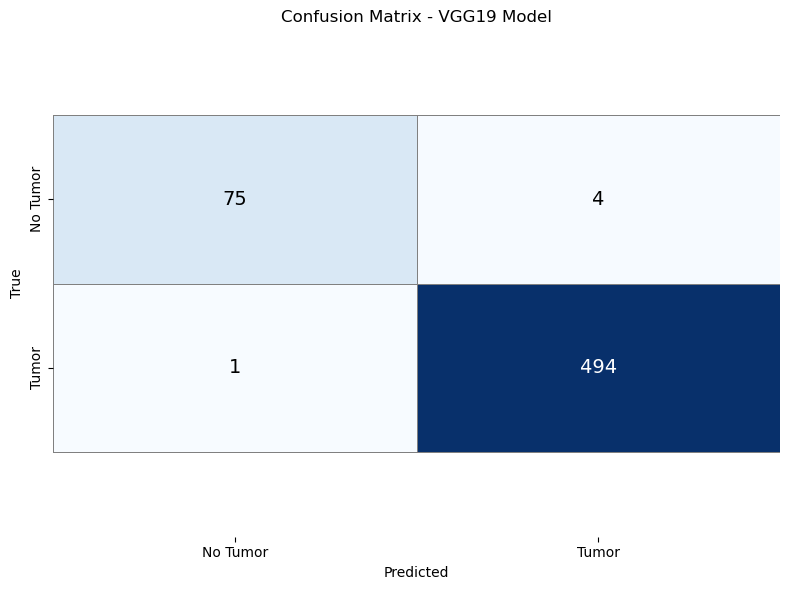

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin test verileri üzerinde tahmin yapması
vgg19.eval()  # veya kullandığın modelin ismi
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19(inputs)  # kullandığın modele göre değiştir
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Etiketler ve sınıf isimleri
labels = [0, 1]
class_names = ['No Tumor', 'Tumor']  # Brain tümör sınıflandırmasına göre isimlendirme

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=labels)
print("VGG19 - Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, labels=labels, target_names=class_names))

# Görselleştirme
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=False, linewidths=0.5, linecolor='gray')

# Sayıları manuel yaz (hem üst hem alt düzgün görünür)
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > threshold else "black"
        ax.text(j + 0.5, i + 0.5, str(value),
                ha='center', va='center', color=color, fontsize=14)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG19 Model')

# Kaymayı engelle (özellikle alt satır için)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.show()


RESNET18 - Confusion Matrix:
[[ 76   3]
 [  2 493]]

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.97      0.96      0.97        79
       Tumor       0.99      1.00      0.99       495

    accuracy                           0.99       574
   macro avg       0.98      0.98      0.98       574
weighted avg       0.99      0.99      0.99       574



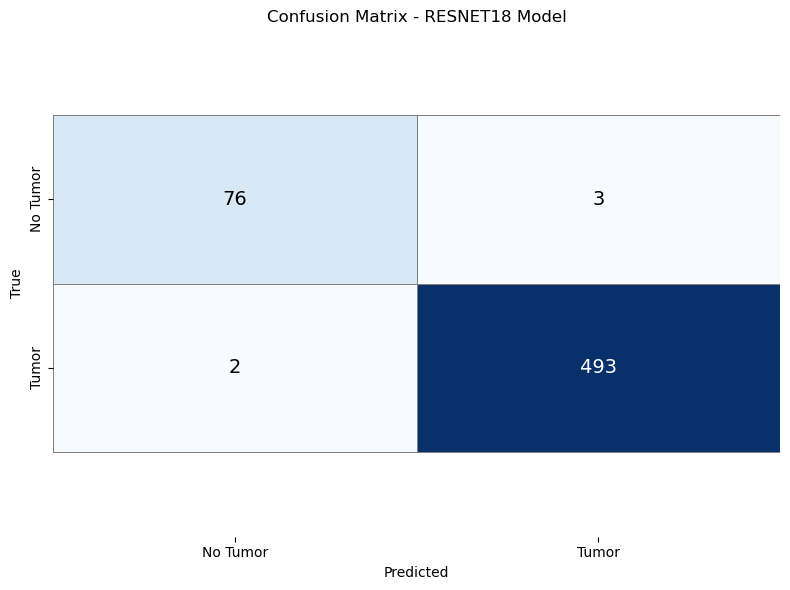

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Modelin test verileri üzerinde tahmin yapması
resnet18.eval()  # veya kullandığın modelin ismi
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)  # kullandığın modele göre değiştir
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Etiketler ve sınıf isimleri
labels = [0, 1]
class_names = ['No Tumor', 'Tumor']  # Brain tümör sınıflandırmasına göre isimlendirme

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=labels)
print("RESNET18 - Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, labels=labels, target_names=class_names))

# Görselleştirme
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=False, linewidths=0.5, linecolor='gray')

# Sayıları manuel yaz (hem üst hem alt düzgün görünür)
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > threshold else "black"
        ax.text(j + 0.5, i + 0.5, str(value),
                ha='center', va='center', color=color, fontsize=14)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RESNET18 Model')

# Kaymayı engelle (özellikle alt satır için)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.show()


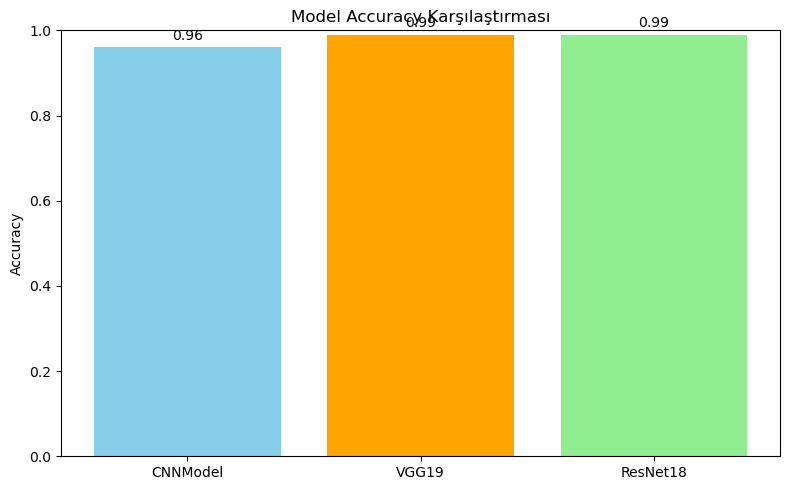

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Güncellenmiş model adları ve doğruluk değerleri
models = ['CNNModel', 'VGG19', 'ResNet18']
accuracies = [0.96, 0.99, 0.99]  # Doğruluk oranları

# Bar grafiği oluşturuluyor
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'lightgreen'])
plt.ylim(0, 1)
plt.title('Model Accuracy Karşılaştırması')
plt.ylabel('Accuracy')

# Barların üstüne değerleri yazma
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Grafik düzenlemeleri
plt.tight_layout()
plt.show()


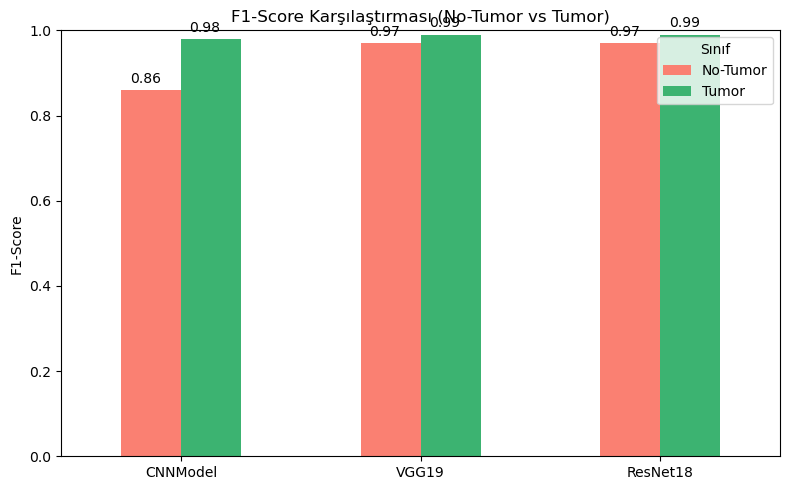

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Güncel classification_report sonuçlarına göre F1-Score değerleri
cnn_f1 = {'No-Tumor': 0.86, 'Tumor': 0.98}      # CNNModel
vgg_f1 = {'No-Tumor': 0.97, 'Tumor': 0.99}      # VGG19
resnet_f1 = {'No-Tumor': 0.97, 'Tumor': 0.99}   # ResNet18

# Pandas DataFrame oluştur
f1_df = pd.DataFrame({
    'CNNModel': cnn_f1,
    'VGG19': vgg_f1,
    'ResNet18': resnet_f1
}).T  # Modeller satırda olsun diye transpose

# Bar grafiği çiz
f1_df.plot(kind='bar', figsize=(8, 5), color=['salmon', 'mediumseagreen'])
plt.title('F1-Score Karşılaştırması (No-Tumor vs Tumor)')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Sınıf")

# Çubukların üzerine değerleri yazdır
for i, model in enumerate(f1_df.index):
    for j, value in enumerate(f1_df.loc[model]):
        plt.text(i + j*0.25 - 0.15, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


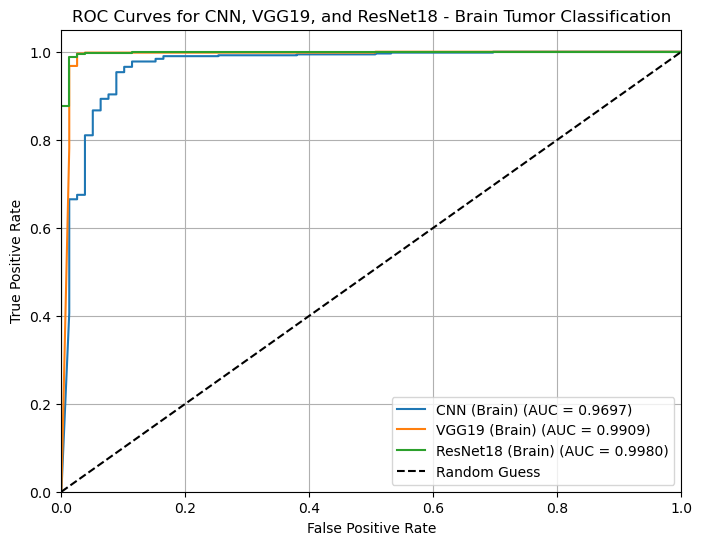

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Probabiliteleri ve etiketleri almak için fonksiyon
def get_probs_and_labels(model, dataloader, device):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Pozitif sınıf (örneğin 'tumor') olasılığı
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_labels, all_probs

# Her model için ROC verilerini al
all_labels_cnn, all_probs_cnn = get_probs_and_labels(cnn_brain, test_loader, device)
all_labels_vgg, all_probs_vgg = get_probs_and_labels(vgg19, test_loader, device)
all_labels_resnet, all_probs_resnet = get_probs_and_labels(resnet18, test_loader, device)

# ROC eğrisi çizme fonksiyonu
def plot_roc_curve(all_labels, all_probs, model_name):
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

# ROC eğrilerini çiz
plt.figure(figsize=(8, 6))

plot_roc_curve(all_labels_cnn, all_probs_cnn, 'CNN (Brain)')
plot_roc_curve(all_labels_vgg, all_probs_vgg, 'VGG19 (Brain)')
plot_roc_curve(all_labels_resnet, all_probs_resnet, 'ResNet18 (Brain)')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN, VGG19, and ResNet18 - Brain Tumor Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
